## Import all necessary packages

In [3]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm


from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [4]:
BASE_DIR = "C:/Users/Swapnali Patil/OneDrive/Desktop/Project Done/Dataset"
WORKING_DIR = "C:/Users/Swapnali Patil/OneDrive/Desktop/Project Done/WORKING_DIR"

## Extract Features From Image

In [5]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [9]:
!pip install graphviz
from graphviz import Digraph

In [11]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

## Load the Captions data

In [13]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [14]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [15]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [16]:
len(mapping)

8091

## Preprocess the Text Data

In [20]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [21]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [22]:
# preprocess the text
clean(mapping)

In [23]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [24]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [25]:
len(all_captions)

40455

In [26]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [27]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [28]:
vocab_size

8485

In [29]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

## Test Train Split

In [31]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [32]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

## Model Creation

In [57]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
#plot_model(model, show_shapes=True)

In [26]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 771s 3s/step - loss: 2.1817


In [35]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

## Generate Captions for the Images

In [37]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [38]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [60]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
predicted,actual = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.027846
BLEU-2: 0.000000


## Result

In [61]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Predicted---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Actual--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Predicted---------------------
startseq soccer player in blue is chasing after the player in black and white endseq
startseq the girl in the white strip is falling down as the girl in the blue strip challenges for the soccer ball endseq
startseq the girls are playing soccer endseq
startseq two women in soccer uniforms playing soccer endseq
startseq two young women on different teams are playing soccer on field endseq
--------------------Actual--------------------
startseq kickboxing kickboxing kickboxing kickboxing kickboxing kickboxing kickboxing kickboxing kickboxing kickboxing kickboxing kickboxing kickboxing kickboxing kickboxing kickboxing kickboxing kickboxing kickboxing kickboxing kickboxing kickboxing kickboxing kickboxing kickboxing kickboxing kickboxing kickboxing kickboxing kickboxing kickboxing kickboxing kickboxing kickboxing kickboxing


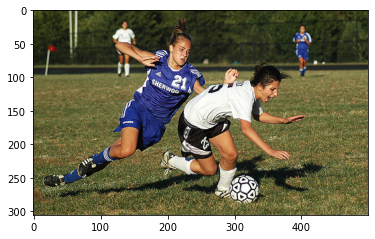

In [62]:
generate_caption("47871819_db55ac4699.jpg")


---------------------Actual---------------------
startseq brown dog is running through brown field endseq
startseq brown dog is running through the field endseq
startseq brown dog with collar runs in the dead grass with his tongue hanging out to the side endseq
startseq brown dog with his tongue wagging as he runs through field endseq
startseq dog running in the grass endseq
--------------------Predicted--------------------
startseq pajama pajama pajama pajama pajama pajama pajama pajama pajama pajama pajama pajama pajama pajama pajama pajama pajama pajama pajama pajama pajama pajama pajama pajama pajama pajama pajama pajama pajama pajama pajama pajama pajama pajama pajama


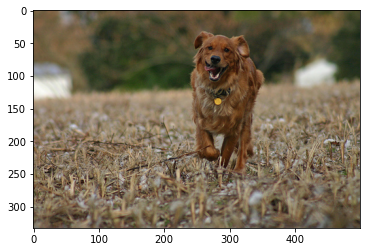

In [45]:
generate_caption("69189650_6687da7280.jpg")

---------------------Actual---------------------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
--------------------Predicted--------------------
startseq two people in red coat and red vests are skiing endseq


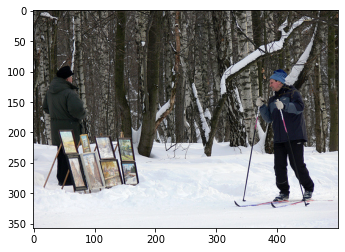

In [54]:
generate_caption("101669240_b2d3e7f17b.jpg")


---------------------Actual---------------------
startseq dog jumps for red ball on the grass endseq
startseq white dog is jumping in the air attempting to catch red ball endseq
startseq white dog jumping to catch red ball endseq
startseq white dog with blue collar plays with red ball endseq
startseq the dog is playing with red ball endseq
--------------------Predicted--------------------
startseq two dogs are playing in the grass with red ball in the background endseq


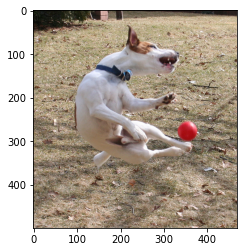

In [39]:
generate_caption("128912885_8350d277a4.jpg")

---------------------Actual---------------------
startseq dog is jumping as he turns around on beach endseq
startseq dog jumps out of the waves at the beach endseq
startseq dog jumps up on the beach with rocks in the foreground endseq
startseq wet dog is jumping through some water on beach endseq
startseq wet dog jumps in the surf endseq
--------------------Predicted--------------------
startseq dog catching wave on the beach endseq


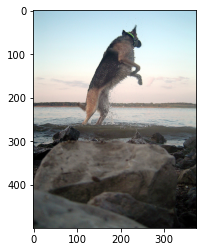

In [46]:
generate_caption("236518934_c62a133077.jpg")

---------------------Actual---------------------
startseq dog is walking along some dry cracked earth endseq
startseq dog walking along cracked and ashen surface endseq
startseq dog walking on mud flats endseq
startseq dog walks across the rocky ground endseq
startseq dog walks through some mud endseq
--------------------Predicted--------------------
startseq dog is walking along the ground endseq


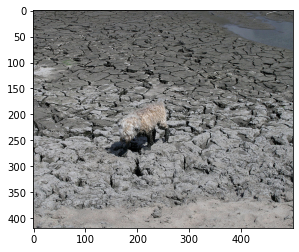

In [45]:
generate_caption("171488318_fb26af58e2.jpg")

---------------------Actual---------------------
startseq few people sit together on the snowy mountaintop endseq
startseq group of climbers rest on summit that overlooks another mountain range endseq
startseq group of mountain climbers rests at the summit endseq
startseq group of people sitting on top of rocks with snow covered mountains on both sides of them endseq
startseq people are sitting on snowy mountain endseq
--------------------Predicted--------------------
startseq mountain climber hikes through the snow endseq


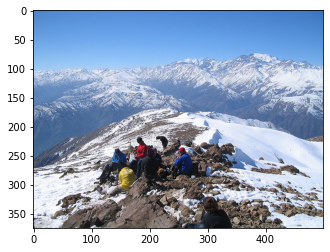

In [44]:
generate_caption("57417274_d55d34e93e.jpg")

---------------------Actual---------------------
startseq couple stands close at the water 's edge endseq
startseq the two people stand by body of water and in front of bushes in fall endseq
startseq two people hold each other near pond endseq
startseq two people stand by the water endseq
startseq two people stand together on the edge of the water on the grass endseq
--------------------Predicted--------------------
startseq two people are walking along the edge of lake endseq


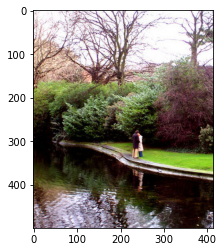

In [43]:
generate_caption("3637013_c675de7705.jpg")